In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import networkx as nx
import numpy as np
import cvxpy as cp
import copy
from tqdm import tqdm
from pathlib import Path

from src.load_data import (
    read_metadata_networks_tntp,
    read_graph_transport_networks_tntp,
    read_traffic_mat_transport_networks_tntp,
)

from src.models import SDModel, BeckmannModel, TwostageModel
from src.algs import subgd, ustm, frank_wolfe, cyclic, N_conjugate_frank_wolfe 
from src.cvxpy_solvers import get_max_traffic_mat_mul
from src.commons import Correspondences
from src.admm_stuff import AdmmOracle, combined_salim

import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatter


plt.rcParams.update({'font.size': 14})
%config InlineBackend.figure_format = 'retina'

%matplotlib inline

In [3]:
networks_path = Path("./TransportationNetworks")

# folder = "SiouxFalls"
# net_name = "SiouxFalls_net"
# traffic_mat_name = "SiouxFalls_trips"

# folder = "Chicago-Sketch"
# net_name = "ChicagoSketch_net"
# traffic_mat_name = "ChicagoSketch_trips"

# Anaheim and Barcelona not working as having non-thru-nodes.
# I'll add support for that in Bmul, BTmul soon

folder = "Anaheim"
net_name = "Anaheim_net"
traffic_mat_name = "Anaheim_trips"
    
# folder = "Barcelona"
# net_name = "Barcelona_net"
# traffic_mat_name = "Barcelona_trips"

    
net_file = networks_path / folder / f"{net_name}.tntp"
traffic_mat_file = networks_path / folder / f"{traffic_mat_name}.tntp"
graph, metadata = read_graph_transport_networks_tntp(net_file)
correspondences = read_traffic_mat_transport_networks_tntp(traffic_mat_file, metadata)
n = graph.number_of_nodes()

print(f"{graph.number_of_edges()=}, {graph.number_of_nodes()=}")


metadata["can_pass_through_zones"]=False
graph.number_of_edges()=914, graph.number_of_nodes()=454


In [4]:
# # This cell is to add some people to replace zeros in traffic maxtrix but not making flow bigger

# tm = correspondences.traffic_mat
# print(tm.sum())
# tm[tm == 0] = 1
# tm[tm > 10] = tm[tm > 10] * 0.952
# tm.sum()

In [5]:
beckmann_model = BeckmannModel(graph, copy.deepcopy(correspondences))

# Twostage

In [31]:
traffic_mat = correspondences.traffic_mat.copy() 
departures, arrivals = traffic_mat.sum(axis=1), traffic_mat.sum(axis=0) 
l, w = departures, arrivals
twostage_beckmann_model = TwostageModel(beckmann_model, departures=departures, arrivals=arrivals, gamma=0.1)
admm_oracle = AdmmOracle(twostage_beckmann_model.traffic_model, twostage_beckmann_model.gamma, l, w)

/home/demyan/reps/mmo_tm/src/admm_stuff.py:24: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence_mat = nx.incidence_matrix(traffic_model.nx_graph, oriented=True).todense()


In [48]:
# for Sioux-Falls
comment = "3FW in cyclic"
ta_epss = list(10.0 ** np.arange(2, -1, -1))
# agd_kwargs = dict(eps_abs=1e-4, iters=1000, M0=10)
# salim_kwargs = dict(eps_abs=1e-5, iters=1000, mu=0.01, L=1)
experiment = {"meta": {"network": folder, "description": comment, },
       "almost_exact" : {"max_iter": 10_000, "ta_eps_abs": 1e-2},
        "cyclic_big_iters": 15,
        "cyclic_ta_iters": 10_000,
        "ta_epss" : ta_epss,
        "salim_kwargs" : dict(mu=1e-4, L=1,lam2=l.size, lam1=3*l.size),
        "salim_iters" : 2000,
        "salim_exact_iters" : 5000,
        "data" : {     
            "dgapss" : None,
            "timess" : None,
            "distss" : None,
            "salim_exact_cons" : None,
            "salim_exact_opt" : None,
            "salim_times" : None,
            "salim_dists" : None,
            },
        }
data = experiment["data"]

In [49]:
# exact solution via cyclic (if it converges better than salim)
output = cyclic(model=twostage_beckmann_model,
                traffic_assigment_eps_abs=experiment["almost_exact"]["ta_eps_abs"],
                traffic_assigment_max_iter=experiment["almost_exact"]["max_iter"],
                max_iter=15,#experiment["meta"]["cyclic_iters"],
                stop_by_crit=False)

times_e_best, flows_e_best, corrs_best, logs, optimal = output
times, dgaps = logs[2], logs[0]
experiment["almost_exact"]["times"] = list(times)
experiment["almost_exact"]["dgaps"] = dgaps 

100%|██████████| 15/15 [01:48<00:00,  7.23s/it]


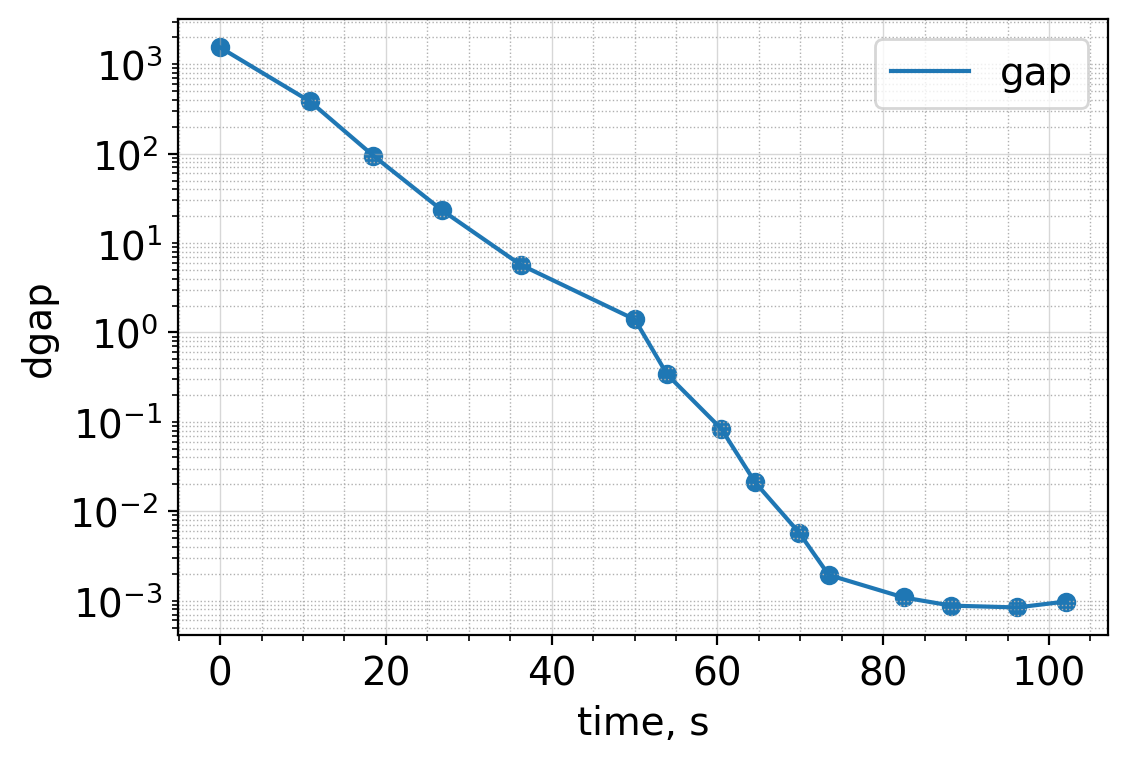

In [50]:
times, dgaps = experiment["almost_exact"]["times"], experiment["almost_exact"]["dgaps"]
ax = plt.figure(figsize=(6,4)).add_subplot(1, 1, 1)
ax.plot(times, dgaps, label=f"gap")
ax.scatter(times, dgaps)

ax.minorticks_on(), ax.set_yscale("log"), ax.set_ylabel("dgap"), ax.set_xlabel("time, s")
minor_locator = LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=12)
ax.yaxis.set_minor_locator(minor_locator)
ax.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5)
ax.grid(which='minor', linestyle=':', linewidth='0.5', alpha=1) 
_ = ax.legend(), plt.show()

In [71]:
salim_kwargs = dict(mu=1e-4, L=1000,lam2=0.001 * l.size, lam1=3.5*l.size)
# salim_kwargs = experiment["salim_kwargs"]
output = combined_salim(admm_oracle, **salim_kwargs, iters=25000, #=experiment["salim_iters"],
               solution_corrs=corrs_best,
               solution_flows=flows_e_best,
               )
corrs_salim, flows_salim, yK_s, yAB_s, dists_s, times_s, pri_res, opt = output

data["salim_times"], data["salim_dists"] = times_s, dists_s

100%|██████████| 25000/25000 [02:08<00:00, 194.04it/s]


Lmax= 6.483788025442847
mumin= 0.00024299141684340015
0.036799655099523 0.3053054230377607 7.32474018004366
salim 24999


(<matplotlib.legend.Legend at 0x7f3f299ecdd0>, None)

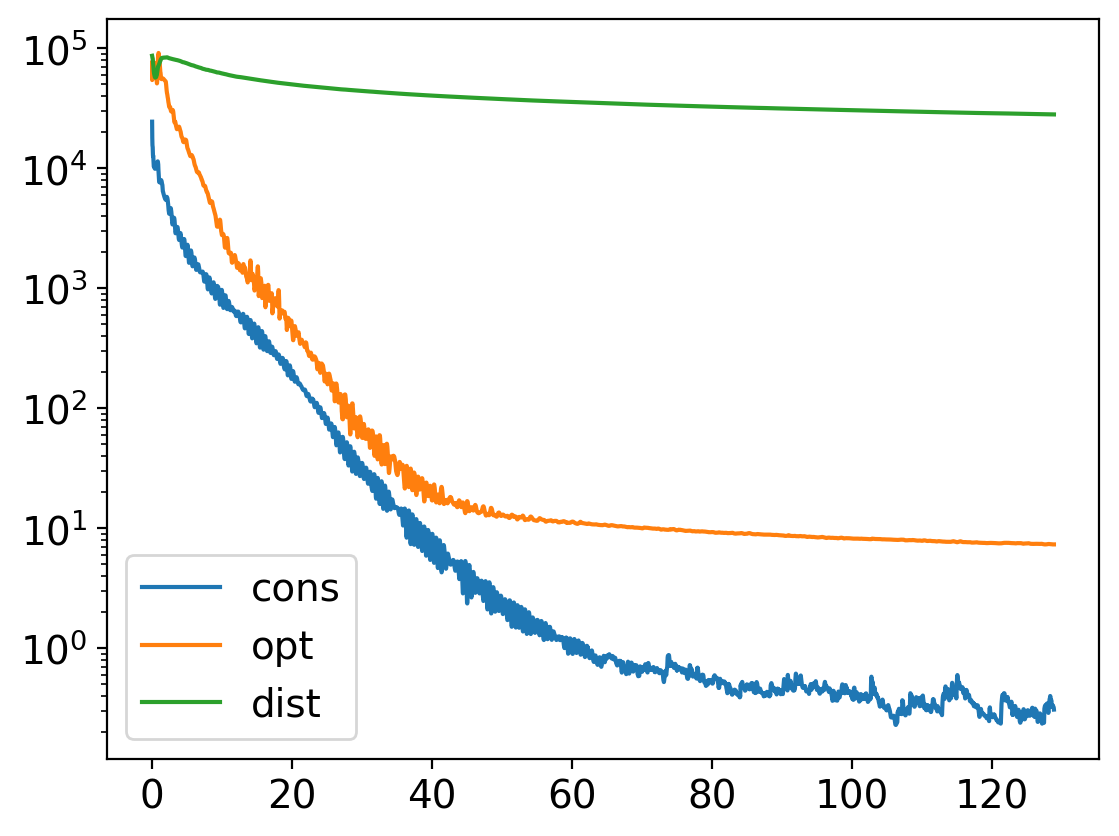

In [75]:
plt.plot(times_s, pri_res, label="cons")
plt.plot(times_s, opt, label="opt")
plt.plot(times_s, dists_s, label="dist")
plt.legend(), plt.yscale("log")


In [53]:
dgapss = []
timess = []
distss = []

for ta_eps in experiment["ta_epss"]:
    output = cyclic(model=twostage_beckmann_model,
                    traffic_assigment_eps_abs=ta_eps, 
                    traffic_assigment_max_iter=experiment["cyclic_ta_iters"], 
                    max_iter=experiment["cyclic_big_iters"], 
                    stop_by_crit=False,
                    solution_flows=flows_e_best,
                    solution_corrs=corrs_best,
                   )
    times_e_cyclic, flows_e_cyclic, d_ij_cyclic, logs, optimal = output
    dgap_cyclic, cons_log_cyclic, time_log_cyclic, dist_flows_log, dist_corrs_log = logs
    
    dgapss.append(dgap_cyclic)    
    timess.append(list(time_log_cyclic))
    distss.append(list((np.array(dist_flows_log) ** 2 + np.array(dist_corrs_log) ** 2) ** 0.5))
    
data["dgapss"] = dgapss
data["timess"] = timess 
data["distss"] = distss 

100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


In [54]:
import json

with open(f"experiments_data/{folder}_salim_vs_cyclic.json", "w") as fp:
    json.dump(experiment, fp)

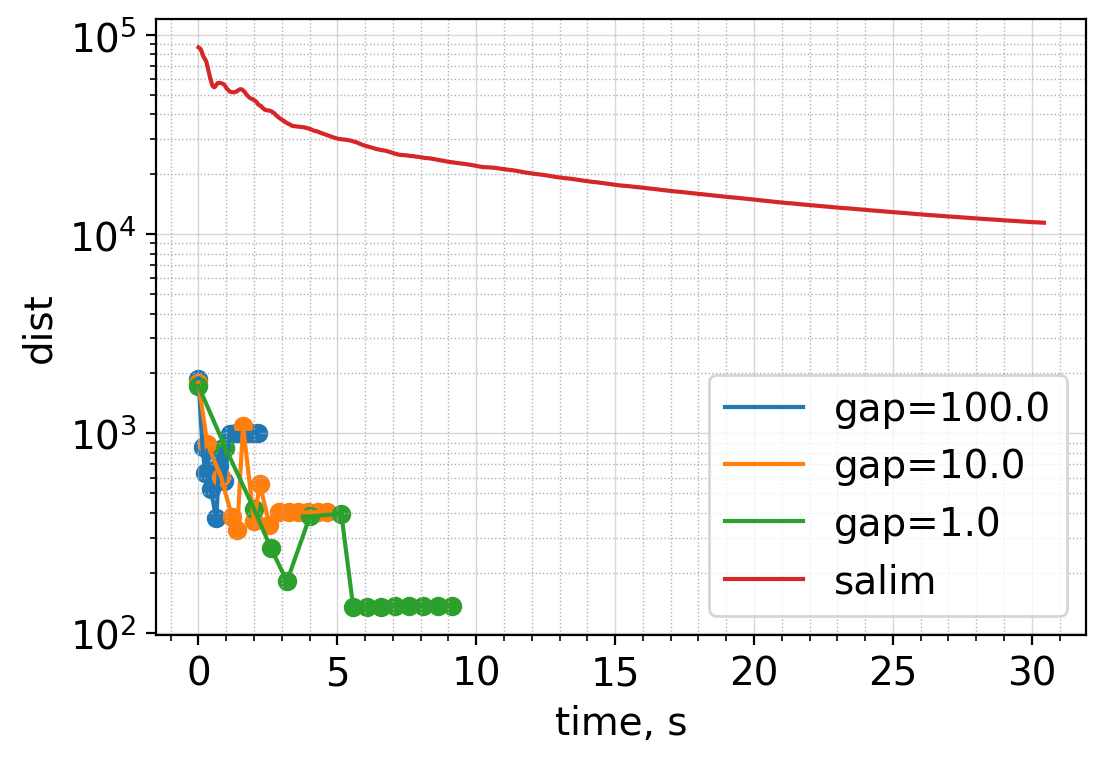

In [73]:
with open(f"experiments_data/{folder}_salim_vs_cyclic.json", "r") as fp:
    experiment = json.load(fp)
data = experiment["data"]
    
plt.figure(figsize=(6,4))

ta_epss = experiment["ta_epss"]
for i in range(len(ta_epss)):
    times, dists = data["timess"][i], data["distss"][i] 
    plt.plot(times, dists, label=f"gap={ta_epss[i]}")
    plt.scatter(times, dists)

plt.plot(data["salim_times"], data["salim_dists"], label="salim")

plt.minorticks_on()
plt.yscale("log")

plt.ylabel("dist")
plt.xlabel("time, s")

minor_locator = LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=12)
plt.gca().yaxis.set_minor_locator(minor_locator)

plt.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5)
plt.grid(which='minor', linestyle=':', linewidth='0.5', alpha=1) 

plt.legend()

plt.savefig(f"experiments_data/{folder}.pdf", bbox_inches="tight")